## Обучение с подкреплением

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm
from multiprocessing import Process

from __future__ import print_function
from abc import ABCMeta, abstractmethod

import seaborn as sns
sns.set_style('darkgrid')

os.makedirs('results', exist_ok=True)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from interfaceAgent import *
from interfaceEnvironment import *
from RLContext import *
from IPython.display import clear_output


import time

In [20]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

### Тестирование отображения карты состояний

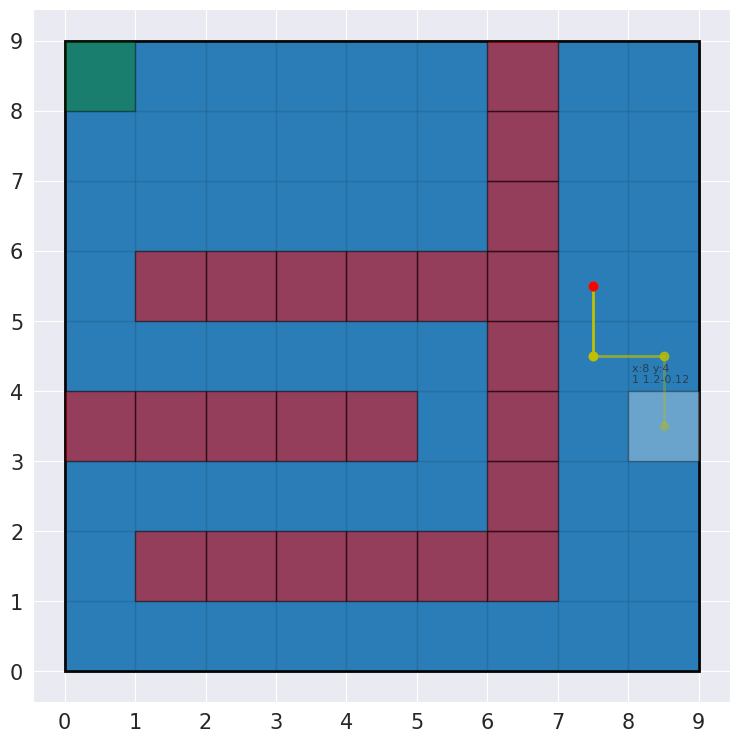

<Figure size 800x500 with 0 Axes>

In [21]:
env_parmas = {
    'map_dim':[9, 9],  
    'obstacles':[[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8],
                [5,1], [4,1], [3,1], [2,1], [1,1],
                [4,3], [3,3], [2,3], [1,3], [0,3],
                [5,5], [4,5], [3,5], [2,5], [1,5],
                ], 
    'start_state':[8,3], 
    'end_state':[0,8], 
    'current_state':[7, 5],
}
#self.steps_agent.append([int(self.past_state), state])
steps_agent = [[83, 84], [84, 74], [74,75]]
q_values = {83:[.1, .2, .3, .4], 84:[.11, .12, .13, .14]}
model = {84:{1:[83,1.2]}}
#self.q_values[int(self.past_state)][int(self.past_action)]

f, a = createField(env_parmas['map_dim'], env_parmas['obstacles'], env_parmas['start_state'], env_parmas['end_state'], env_parmas['current_state'])
print_path_agent(a, f, 
                 env_parmas['current_state'], 
                 env_parmas['map_dim'], 
                 steps_agent, 
                 model,
                 q_values)
#plt.title(f" Планирование на {self.agent.planning_steps} шагов №{self.num_episodes}, шаг {self.num_steps} получено очков {self.total_reward}:", fontsize = 16)

plt.show()

plt.close(f)
plt.clf()

### Класс окружающей среды

In [22]:
class MapEnvironment(InterfaceEnvironment):
    def __init__(self, env_params):
        self.map_dim = env_params['map_dim']
        self.obstacles = env_params['obstacles']

        self.start_state = env_params['start_state']
        self.end_state = env_params['end_state']
        self.current_state = env_params['current_state']

        reward = None
        observation = None
        termination = None
        self.reward_obs_term = [reward, observation, termination]

    def init(self, agent_info={}):
        self.reward_obs_term = [0.0, None, False]

    def start(self):
        self.current_state = self.start_state
        self.reward_obs_term[1] = self.get_observation(self.current_state)
        return self.reward_obs_term[1]

    # проверьте, находится ли текущее состояние в пределах карты
    def out_of_bounds(self, row, col):
        if row < 0 or row > self.map_dim[0]-1 or col < 0 or col > self.map_dim[1]-1:
            return True
        else:
            return False

    # проверьте, есть ли препятствие на (row, col)
    def is_obstacle(self, row, col):
        if [row, col] in self.obstacles:
            return True
        else:
            return False

    def get_observation(self, state):
        return state[0] * 10 + state[1]

    def next_step(self, action):
        reward = 0.0
        is_terminal = False

        row = self.current_state[0]
        col = self.current_state[1]

        # обновите current_state с помощью действия (также проверьте действительность действия)
        if action == 0: # вверх
            if not (self.out_of_bounds(row-1, col) or self.is_obstacle(row-1, col)):
                self.current_state = [row-1, col]

        elif action == 1: # право
            if not (self.out_of_bounds(row, col+1) or self.is_obstacle(row, col+1)):
                self.current_state = [row, col+1]

        elif action == 2: # вниз
            if not (self.out_of_bounds(row+1, col) or self.is_obstacle(row+1, col)):
                self.current_state = [row+1, col]

        elif action == 3: # левый
            if not (self.out_of_bounds(row, col-1) or self.is_obstacle(row, col-1)):
                self.current_state = [row, col-1]

        if self.current_state == self.end_state: # завершить, если цель достигнута
            reward = 1.0
            is_terminal = True

        self.reward_obs_term = [reward, self.get_observation(self.current_state), is_terminal]

        return self.reward_obs_term

    def cleanup(self):
        current_state = None

    def request(self, data):
        if message == "какова текущая награда?":
            return "{}".format(self.reward_obs_term[0])
        return "Я не знаю, как ответить на ваше сообщение"

### Класс агента

In [23]:
import random


class Agent(InterfaceAgent):
    def init(self, agent_info):
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("Вам нужно передать как 'num_states', так и 'num_actions' в agent_info, чтобы инициализировать таблицу значений действий")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1) 
        self.criteria_explored = agent_info.get("criteria_explored", 0.001)
        self.num_episodes = agent_info.get("num_episodes", 0)
        self.planning_steps = agent_info.get("planning_steps", 10)
        
        
        if self.num_episodes > 10 and self.planning_steps > 10:
            self.planning_steps = 10
        if self.num_episodes > 20 and self.planning_steps > 5:
            self.planning_steps = 10
        
        
        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))
        self.is_dynamic_map_state = agent_info.get("is_dynamic_map_state", False)
        self.q_values = {}#np.zeros((self.num_states, self.num_actions))
        self.steps_agent = []
        self.actions = list(range(self.num_actions))
        self.unexplored_map_reword = {}
        self.unexplored = set()
        
        self.coff_new_unexplored = 5
        self.coff_new_unexplored_diff_way = 0
        self.explored_map_reword_increase = .3
        self.unexplored_map_reword_increase = 5
        
        self.past_action = -1
        self.past_state = -1
        self.model = {}
        self.action_diff = {0:2, 1:3, 2:0, 3:1}
        
    def update_model(self, past_state, past_action, state, reward):
        if past_state in self.model.keys():
            self.model[past_state][past_action] = (state, reward)
            for action in self.actions:
                if action != past_action:
                    self.model[past_state][action] = (past_state, 0)
        else:
            self.model[past_state] = { past_action : (state, reward) }
            
            
    def planning_step(self):
        self.planning_step_fast_search_2()

                
    def planning_step_fast_search_2(self):
        for i in range(self.planning_steps):
            select_state = self.planning_rand_generator.choice( list(self.model.keys()))
            select_action = self.planning_rand_generator.choice(list(self.model[select_state].keys()))
            
            m_next_state, m_reward = self.model[select_state][select_action]

            if int(select_state) not in self.unexplored_map_reword.keys():
                self.unexplored_map_reword[int(select_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
                
            #if len(self.steps_agent) > 3:
            m_reward += self.criteria_explored * np.sqrt(self.unexplored_map_reword[select_state][select_action]) * (len(self.steps_agent)**2/100 if len(self.steps_agent) <= 10 else 1)

            if m_next_state not in self.q_values.keys():
                self.q_values[m_next_state] = np.zeros(self.num_actions)
                for pos_action in range(len(self.q_values[m_next_state])): 
                    self.unexplored.add((m_next_state, pos_action))
                    
            if select_state not in self.q_values.keys():
                self.q_values[select_state] = np.zeros(self.num_actions)
                for pos_action in range(len(self.q_values[select_state])): 
                    self.unexplored.add((select_state, pos_action))
                    
            q_max = 0 if select_state == -1 else self.q_values[m_next_state][self.argmax(self.q_values[m_next_state])]
            

            self.q_values[select_state][select_action] += self.step_size * (m_reward + self.gamma * q_max - self.q_values[select_state][select_action])
            
                
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    
    def choose_action_egreedy(self, state):
        if state not in self.q_values.keys():
            self.q_values[state] = np.zeros((self.num_actions))
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
                
        unexplored_actions = [e for e in self.unexplored if e[0] == state]
        if len(unexplored_actions) and random.random() > 0.5:
            action = random.choice(unexplored_actions)[1]
            
        elif self.rand_generator.rand() < self.epsilon:
            p = self.q_values[state]+1e-16+np.abs(np.min(self.q_values[state]))
            p /= np.sum(p)
            p = np.abs(p - 1)
            p /= np.sum(p)            
            action = np.random.choice(self.actions, p=p)
        else:
            values = self.q_values[state]
            unique = np.unique(values)
            if len(unique) == 1:
                action = np.random.choice(self.actions)
            else:
                action = self.argmax(values)

        return action
    
    
    def start(self, state):
        self.past_state = state
        if state not in self.q_values.keys():
            self.q_values[state] = np.zeros((self.num_actions))
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
        
        self.past_action = self.choose_action_egreedy(state)
        self.steps_agent.append([state,state])
        return self.past_action
    
    
    def update_unexplored_map_reword(self):
        if len(self.unexplored) != 0 or self.is_dynamic_map_state:
            if len(self.steps_agent) % 2 == 0:
                for key in self.unexplored_map_reword.keys():
                    self.unexplored_map_reword[key] += random.random() * self.explored_map_reword_increase
                for (state, action) in self.unexplored:
                    if int(state) not in self.unexplored_map_reword.keys():
                        self.unexplored_map_reword[int(state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
                        self.unexplored_map_reword[state][self.action_diff[action]] = self.coff_new_unexplored_diff_way
                    self.unexplored_map_reword[state][action] += self.unexplored_map_reword_increase
    
    
    
    def next_step(self, reward, state):
        if (self.past_state, self.past_action) in self.unexplored:
            self.unexplored.remove((self.past_state, self.past_action))
        self.update_unexplored_map_reword()
            
        if int(self.past_state) not in self.unexplored_map_reword.keys():
            self.unexplored_map_reword[int(self.past_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
            self.unexplored_map_reword[self.past_state][self.action_diff[self.past_action]] = self.coff_new_unexplored_diff_way
            
        if state not in self.q_values.keys():
            self.q_values[state] = np.zeros((self.num_actions))
            for pos_action in range(len(self.q_values[state])): 
                self.unexplored.add((state, pos_action))
            
        self.unexplored_map_reword[int(self.past_state)][(self.past_action)] = 0
        while True:
            max_action = self.choose_action_egreedy(state)
            if (state, max_action) != (self.past_state, self.past_action):
                break
        self.q_values[int(self.past_state)][int(self.past_action)] += self.step_size * ((reward + self.gamma * self.q_values[int(state)][int(max_action)]) - self.q_values[int(self.past_state)][int(self.past_action)])

        self.update_model(int(self.past_state), int(self.past_action), state, reward)
        #if len(self.steps_agent) % 2 != 0:
        self.planning_step()
        self.steps_agent.append([int(self.past_state), int(state)])
        self.past_state = int(state)
        self.past_action = int(max_action)   
        if (state, max_action) in self.unexplored:
            self.unexplored.remove((state, max_action)) 
        if int(state) not in self.unexplored_map_reword.keys():
            self.unexplored_map_reword[state] = np.ones((self.num_actions)) * self.coff_new_unexplored
            self.unexplored_map_reword[state][self.action_diff[max_action]] = self.coff_new_unexplored_diff_way
        self.unexplored_map_reword[state][max_action] = 0
        return self.past_action

    
    def end(self, reward):    
        self.q_values[int(self.past_state)][int(self.past_action)] += self.step_size * (reward - self.q_values[int(self.past_state)][int(self.past_action)])
        
        self.update_unexplored_map_reword()
            
        if int(self.past_state) not in self.unexplored_map_reword.keys():
            self.unexplored_map_reword[int(self.past_state)] = np.ones((self.num_actions)) * self.coff_new_unexplored
            self.unexplored_map_reword[self.past_state][self.action_diff[self.past_state]] = 0
            
        self.unexplored_map_reword[self.past_state][self.past_action] = 0
        
        self.update_model(int(self.past_state), int(self.past_action), -1, reward)
        #if len(self.steps_agent) % 2 != 0:
        self.planning_step()
        
        
    def cleanup(self):
        pass

    
    def request(self, data):
        pass

### Отображение результатов

In [24]:
def run_experiment(env, agent, env_parmas, env_parameters, agent_parameters, exp_parameters, show_map=True):
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" :  agent_parameters["num_states"],
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon":      agent_parameters["epsilon"], 
                  "discount":     env_parameters["discount"],
                  "step_size" :   agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes))
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):
        print('Этапы планирования: ', planning_steps)
        os.system('sleep 0.5')
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):
        #for i in range(num_runs):
            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_context = RLContext(env, env_parmas, agent, show_map=show_map)
            rl_context.init(agent_info, env_info)
            rl_context.idx_image = 1
    
            for j in range(num_episodes):
                rl_context.episode(exp_parameters["count_max_step"])
                all_averages[idx][i][j] = rl_context.num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):
    data = np.load(file_path, allow_pickle=True).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Этапы планирования = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Эпизоды')
    plt.ylabel('Кол. шагов за эпизод', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

### Отобразить графики эффективности при планировании 

Этапы планирования:  0


100%|##########| 30/30 [00:12<00:00,  2.33it/s]


Этапы планирования:  1


100%|##########| 30/30 [00:31<00:00,  1.05s/it]


Этапы планирования:  2


100%|##########| 30/30 [00:33<00:00,  1.13s/it]


Этапы планирования:  3


100%|##########| 30/30 [00:35<00:00,  1.20s/it]


Этапы планирования:  4


100%|##########| 30/30 [00:42<00:00,  1.40s/it]


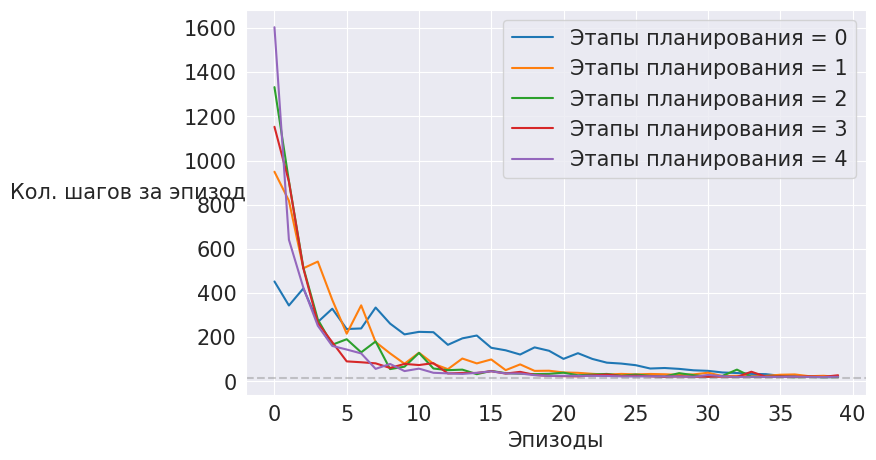

In [26]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 30,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 40,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 1, 2, 3, 4]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],  
    'obstacles':[[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]], 
    'start_state':[8,3], 
    'end_state':[0,8], 
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

Этапы планирования:  0


100%|##########| 30/30 [00:12<00:00,  2.35it/s]


Этапы планирования:  5


100%|##########| 30/30 [00:45<00:00,  1.50s/it]


Этапы планирования:  10


100%|##########| 30/30 [00:59<00:00,  1.97s/it]


Этапы планирования:  20


100%|##########| 30/30 [01:15<00:00,  2.51s/it]


Этапы планирования:  25


100%|##########| 30/30 [01:41<00:00,  3.38s/it]


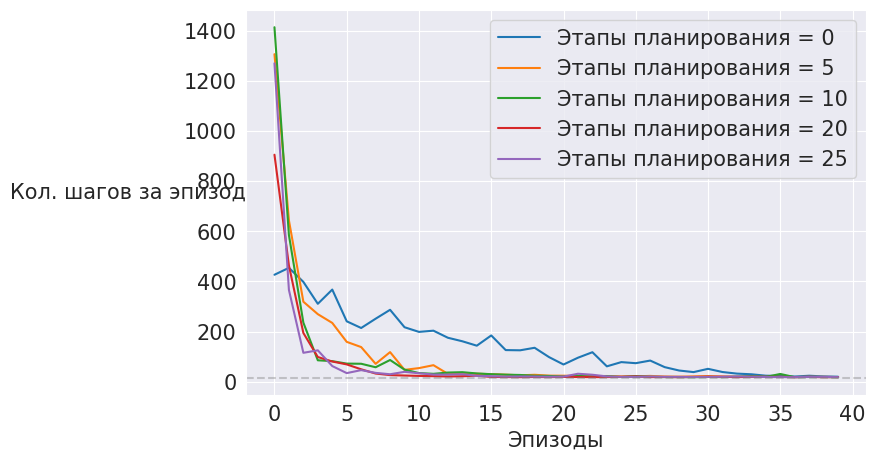

In [25]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 30,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 40,                 # Количество эпизодов в эксперименте
    "count_max_step": 3000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 10, 20, 25]       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],  
    'obstacles':[[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]], 
    'start_state':[8,3], 
    'end_state':[0,8], 
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=False)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

### Отображение и запись поведения агента на карте состояний

In [ ]:
# Параметры эксперимента
experiment_parameters = {
    "num_runs" : 1,                     # Количество раз, когда мы проводим эксперимент
    "num_episodes" : 40,                 # Количество эпизодов в эксперименте
    "count_max_step" : 4000,
}

# Параметры окружающей среды
environment_parameters = { 
    "discount": 0.95,
}

# Параметры агента
agent_parameters = {
    "num_states" : 81,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [10],       # Список шагов планирования, которые мы хотим попробовать
}

current_env = MapEnvironment   # Окружающая среда
current_agent = Agent          # Агент

env_parmas = {
    'map_dim':[9, 9],
    'obstacles':[[6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7]],
    'rewords_to_state':{"end_state":1.0, "empty":0.0, "hitting_wall":-0.2, "pit":-5},
    'reword_to_action':{"door":0.2},
    'end_position':["pit"],
    
    'start_state':[8,3],
    'end_state':[0,8],
    'current_state':[None, None],
}

run_experiment(current_env, current_agent, env_parmas, environment_parameters, agent_parameters, experiment_parameters, show_map=True)
plot_steps_per_episode('results/Q_planning_steps.npy')
shutil.make_archive('results', 'zip', 'results');

<Figure size 800x500 with 0 Axes>